## Setup

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import os
import time
import json
from tqdm import tqdm
from datasets import load_dataset, concatenate_datasets

import config
from utils import *

os.environ['OPENAI_API_KEY'] = config.OPENAI_API_KEY

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import openai
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from repl.server import LeanServer, RobustLeanServer

## Baseline

In [35]:
json_file_path = '/home/agatha/Desktop/MA3/sem proj/autoformalization_with_hypothesis/results/evaluations/baseline_direct_translation_gpt-4o_evaluated.json'
with open(json_file_path, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()


,name,informal_statement,generated_formal_statement,formal_statement,tags,header,split,model,provider,bleu,cosine_similarity,repl_errors
0,f2f_numbertheory_4x3m7y3neq2003,/-- Show that there are no integers $x$ and $y...,"theorem no_integers_solution : ¬ ∃ (x y : ℤ), ...",theorem numbertheory_4x3m7y3neq2003 (x y : ℤ) ...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai,0.155205,0.902057,[]
1,f2f_mathd_numbertheory_3,/-- What is the units digit of the sum of the ...,theorem units_digit_sum_squares_first_nine : \...,theorem mathd_numbertheory_3 : (∑ x in Finset....,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai,0.394433,0.896831,"[{'severity': 'error', 'pos': {'line': 8, 'col..."
2,f2f_mathd_numbertheory_1124,/-- The four-digit number $\underline{374n}$ i...,theorem find_units_digit (n : ℕ) (h : 0 ≤ n ∧ ...,theorem mathd_numbertheory_1124 (n : ℕ) (h₀ : ...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai,0.355652,0.897501,[]
3,f2f_mathd_numbertheory_237,/-- What is the modulo $6$ remainder of the su...,theorem sum_mod_6_remainder : (∑ i in finset.r...,theorem mathd_numbertheory_237 : (∑ k in Finse...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai,0.514973,0.892778,"[{'severity': 'error', 'pos': {'line': 8, 'col..."
4,f2f_mathd_numbertheory_299,/-- What is the ones digit of $1 \cdot 3 \cdot...,theorem ones_digit_of_product_is_five : \n (1...,theorem mathd_numbertheory_299 : 1 * 3 * 5 * 7...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai,0.738998,0.886377,[]


Average BLEU score: 0.26538502712401885
Average Cosine Similarity: 0.8953934560493993


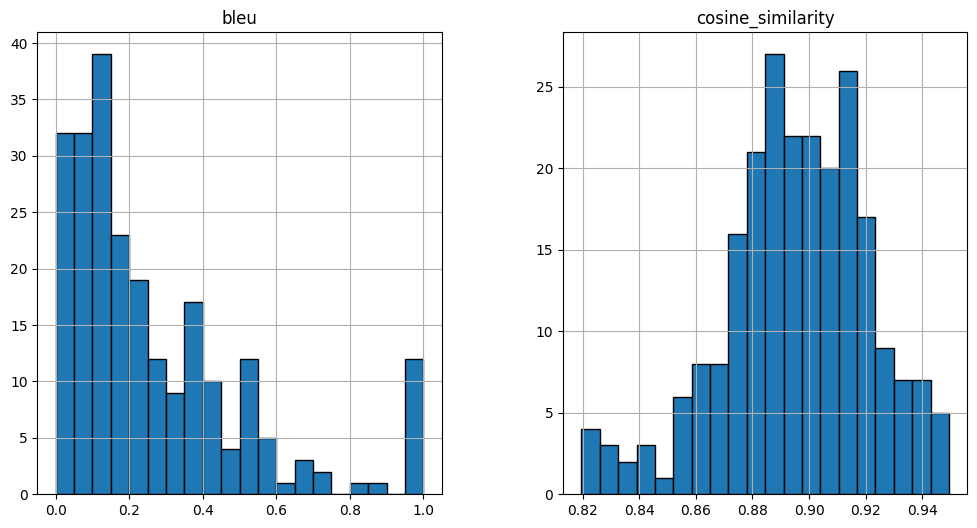

In [28]:
average_bleu = df['bleu'].mean()
average_cosine_similarity = df['cosine_similarity'].mean()

print(f"Average BLEU score: {average_bleu}")
print(f"Average Cosine Similarity: {average_cosine_similarity}")

df[['bleu', 'cosine_similarity']].hist(bins=20, figsize=(12, 6), layout=(1, 2), edgecolor='black')
plt.show()

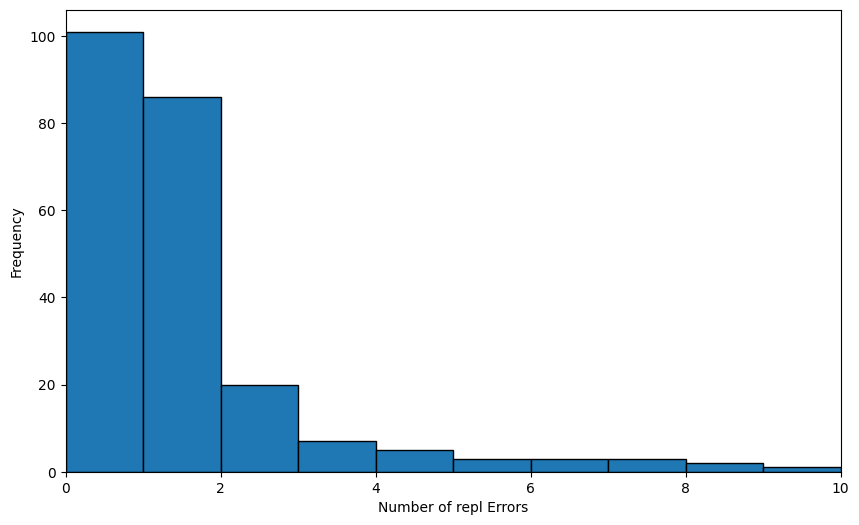

In [25]:
df['num_repl_errors'] = df['repl_errors'].apply(len)


plt.figure(figsize=(10, 6))
plt.hist(df['num_repl_errors'], bins=range(0, 26), edgecolor='black')
plt.xlabel('Number of REPL Errors')
plt.ylabel('Frequency')
plt.xlim(0, 10)

plt.show()

Average TC-BLEU score: 0.1771904067417364


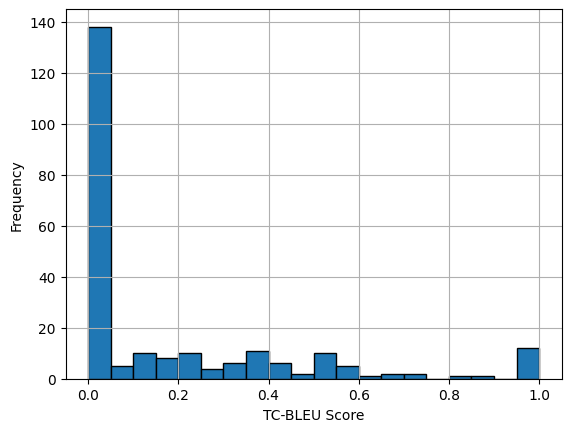

In [14]:
df['TC-BLEU'] = df.apply(lambda row: 0 if row['num_repl_errors'] > 0 else row['bleu'], axis=1)

average_tc_bleu = df['TC-BLEU'].mean()
print(f"Average TC-BLEU score: {average_tc_bleu}")

df['TC-BLEU'].hist(bins=20, edgecolor='black')
plt.xlabel('TC-BLEU Score')
plt.ylabel('Frequency')
plt.show()

## Fewshot

In [29]:
json_file_path = '/home/agatha/Desktop/MA3/sem proj/autoformalization_with_hypothesis/results/evaluations/direct_translation_with_general_fewshot_gpt-4o_evaluated.json'
with open(json_file_path, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()


,name,informal_statement,generated_formal_statement,formal_statement,tags,header,split,model,provider,bleu,cosine_similarity,repl_errors
0,f2f_numbertheory_4x3m7y3neq2003,/-- Show that there are no integers $x$ and $y...,theorem no_integers_satisfy_equation : ¬∃ (x y...,theorem numbertheory_4x3m7y3neq2003 (x y : ℤ) ...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai,0.154210,0.900158,[]
1,f2f_mathd_numbertheory_3,/-- What is the units digit of the sum of the ...,theorem units_digit_sum_squares_first_nine : \...,theorem mathd_numbertheory_3 : (∑ x in Finset....,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai,0.498835,0.891059,[]
2,f2f_mathd_numbertheory_1124,/-- The four-digit number $\underline{374n}$ i...,theorem units_digit_of_divisible_by_18 : ∃ n :...,theorem mathd_numbertheory_1124 (n : ℕ) (h₀ : ...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai,0.202240,0.876434,[]
3,f2f_mathd_numbertheory_237,/-- What is the modulo $6$ remainder of the su...,theorem sum_mod_six_remainder : (∑ i in Finset...,theorem mathd_numbertheory_237 : (∑ k in Finse...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai,0.577350,0.889196,[]
4,f2f_mathd_numbertheory_299,/-- What is the ones digit of $1 \cdot 3 \cdot...,theorem ones_digit_of_product_is_five : (1 * 3...,theorem mathd_numbertheory_299 : 1 * 3 * 5 * 7...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai,0.738998,0.879160,[]


Average BLEU score: 0.271397929512879
Average Cosine Similarity: 0.8924129574756129


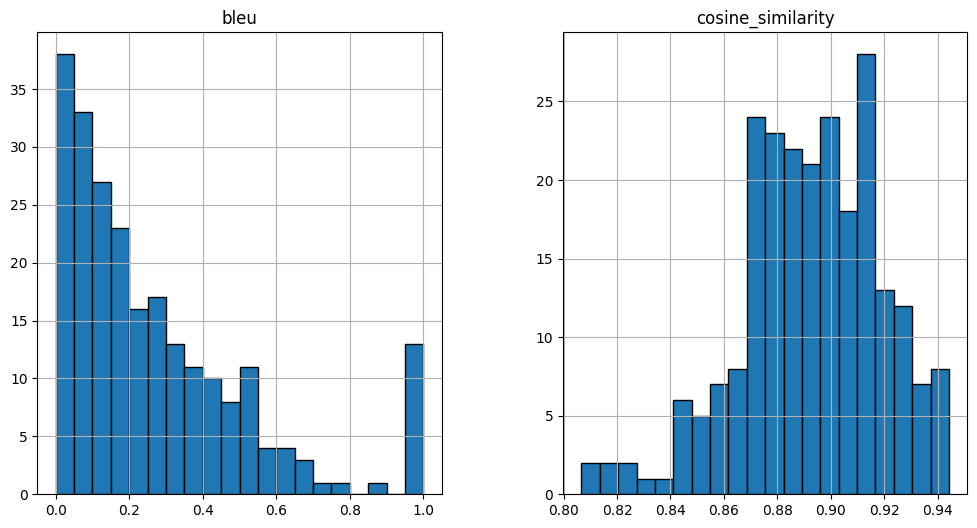

In [30]:
average_bleu = df['bleu'].mean()
average_cosine_similarity = df['cosine_similarity'].mean()

print(f"Average BLEU score: {average_bleu}")
print(f"Average Cosine Similarity: {average_cosine_similarity}")

df[['bleu', 'cosine_similarity']].hist(bins=20, figsize=(12, 6), layout=(1, 2), edgecolor='black')
plt.show()

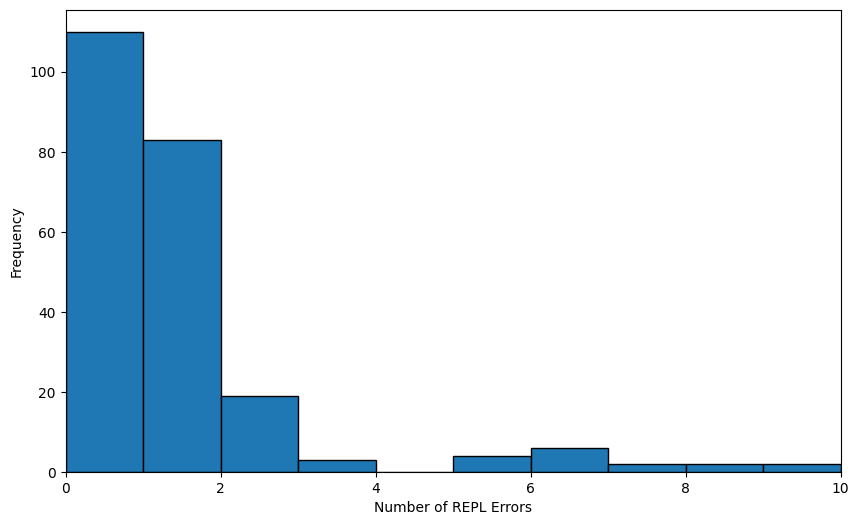

In [31]:
df['num_repl_errors'] = df['repl_errors'].apply(len)


plt.figure(figsize=(10, 6))
plt.hist(df['num_repl_errors'], bins=range(0, 26), edgecolor='black')
plt.xlabel('Number of REPL Errors')
plt.ylabel('Frequency')
plt.xlim(0, 10)

plt.show()

Average TC-BLEU score: 0.19534738699454512


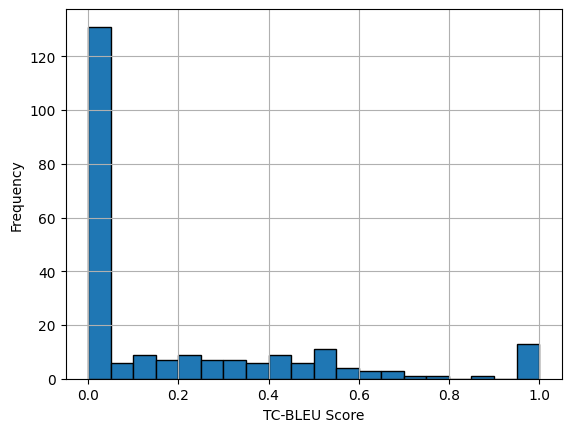

In [32]:
df['TC-BLEU'] = df.apply(lambda row: 0 if row['num_repl_errors'] > 0 else row['bleu'], axis=1)

average_tc_bleu = df['TC-BLEU'].mean()
print(f"Average TC-BLEU score: {average_tc_bleu}")

df['TC-BLEU'].hist(bins=20, edgecolor='black')
plt.xlabel('TC-BLEU Score')
plt.ylabel('Frequency')
plt.show()

## look

In [38]:
row = df.iloc[210]
print(row.informal_statement)
print(row.generated_formal_statement)
print(row.formal_statement)

Prove that, for infinitely many positive integers $n$, all primes $p$ that divide $n^2 + 3$ also divide $k^2 + 3$ for some integer $k$ such that $k^2 < n$.
theorem infinitely_many_n_exists_k (h : ∀ n : ℕ, ∃ k : ℤ, k^2 < n ∧ ∀ p : ℕ, p.prime → p ∣ n^2 + 3 → p ∣ k^2 + 3) : ∃ᶠ n in at_top, ∃ k : ℤ, k^2 < n ∧ ∀ p : ℕ, p.prime → p ∣ n^2 + 3 → p ∣ k^2 + 3 :=
sorry
theorem putnam_1981_b3
(P : ℕ → Prop := fun n : ℕ => ∀ p : ℕ, (Nat.Prime p ∧ p ∣ n^2 + 3) → ∃ k : ℕ, (p : ℤ) ∣ (k : ℤ)^2 + 3 ∧ k^2 < n)
: ∀ n : ℕ, ∃ m : ℕ, (m : ℤ) > n ∧ P m :=
sorry
